# Deep Q-Network

In [44]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random
import matlab.engine

In [45]:
eng=matlab.engine.start_matlab()

In [46]:
#Global Variables
EPISODES = 1
TRAIN_END = 0

In [47]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 20

In [48]:
R=[]

In [49]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=250000)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() 
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) 
        model.add(keras.layers.Dense(24, activation='relu')) 
        model.add(keras.layers.Dense(self.nA, activation='linear')) 
        model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(lr=self.alpha)) 
        return model
    import math

    def sigmoid(x):
        return 1 / (1 + math.exp(-x))
    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0,3,(int(nA/3)))
        action_vals = self.model.predict(state) 
        temp=np.array(action_vals[0]);
        action_2d=np.reshape(temp, (int(nA/3), 3));
        action_val=np.argmax(action_2d, axis=1);
        return action_val

    def test_action(self, state): 
        temp=np.array(action_vals[0]);
        action_2d=np.reshape(temp, (int(nA/3), 3));
        action_val=np.argmax(action_2d, axis=1);
        return action_val

    def store(self, state, action, reward, nstate, done):
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        minibatch = random.sample( self.memory, batch_size ) 
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) 
        nst = np.zeros((0,self.nS))
        for i in range(len(np_array)): 
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st)
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            nst_action_predict_model = nst_predict[index]
            nst_action_predict_model_2d= np.reshape(nst_action_predict_model, (int(nA/3), 3));
            target=np.zeros(int(nA/3));
            if done == True: 
                target = target + reward
            else:   
                target = reward + self.gamma * np.amax(nst_action_predict_model_2d, axis=1);
            qtobeupdated= np.argmax(nst_action_predict_model_2d, axis=1);
            target_f = st_predict[index]           
            for i in range(int(nA/3)):
              cnt=i*3+qtobeupdated[i];
              target_f[cnt]=target[i];
                
            y.append(target_f)
            index += 1

        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [50]:
#Create the agent
nS = 10
nA = 3*nS
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

batch_size = batch_size()

In [51]:
print(nS)

10


In [55]:
basepower=1;
powerratio=10;
numberoflevels=3;
maxpower=basepower* (powerratio ** (numberoflevels -1));

In [ ]:
#Training
rewards = [] 
epsilons = [] 
TEST_Episodes = 0
for e in range(EPISODES):
    state = np.zeros(nS) 
    state=state+basepower;
    nstate = np.zeros(nS) 
    tot_rewards = 0
    for time in range(1000): 
        action_val = dqn.action(state)
        state = np.reshape(state,nS);
        nstate = np.reshape(nstate,nS);
        nstate[action_val==2]=state[action_val==2]*powerratio;
        nstate[action_val==0]=state[action_val==0]/powerratio;
        nstate[action_val==1]=state[action_val==1];
        nstate[nstate<basepower]=basepower;
        nstate[nstate>maxpower]=maxpower;
        
        xnstate= matlab.double(nstate.tolist())
        reward= eng.fxn(xnstate);
        print(time,':',reward,nstate)
        R.append(reward)
        done =False
        
        tot_rewards += reward
        state = np.reshape(state, [1, nS])
        nstate = np.reshape(nstate, [1, nS])
        dqn.store(state, action_val, reward, nstate, done) 
        state = nstate
        if done or time == 1000:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)


0 : 130.5708869443878 [ 1.  1. 10. 10.  1.  1.  1. 10. 10. 10.]
1 : 113.3239910549212 [  1.  10.  10.  10.   1.   1.  10. 100. 100.   1.]
2 : 132.75224246072915 [  1.  10.  10. 100.   1.   1. 100.  10. 100.   1.]
3 : 116.45150936261288 [ 10.   1.   1.  10.   1.   1.  10.   1. 100.   1.]
4 : 119.34670704725957 [ 10.  10.   1. 100.   1.   1.  10.   1. 100.   1.]
5 : 119.25320150812371 [  1. 100.   1. 100.  10.   1. 100.   1. 100.  10.]
6 : 123.31972344263417 [  1.  10.   1.  10.   1.   1. 100.   1. 100.   1.]
7 : 131.54718855958438 [ 10.   1.  10.  10.   1.   1. 100.  10. 100.  10.]


In [132]:
import csv
with open('Reward','w') as f:
    write = csv.writer(f)
    write.writerow(R)

In [133]:
eng.quit()

In [134]:
for e_test in range(TEST_Episodes):
    state = np.zeros(nS) # Resize to store in memory to pass to .predict
    #define start state here
    nstate = np.zeros(nS) 
    tot_rewards = 0
    for t_test in range(210):
        # action = dqn.test_action(state)
        # nstate, reward, done, _ = envCartPole.step(action)
        # nstate = np.reshape( nstate, [1, nS])
        action_val = dqn.action(state)

        nstate[action_val==2]=state[action_val==2]*powerratio;
        nstate[action_val==0]=state[action_val==0]/powerratio;
        nstate[action_val==1]=state[action_val==1];
        nstate[nstate<basepower]=basepower;
        nstate[nstate>maxpower]=maxpower;
        # action = dqn.action(state)
        # nstate[action>=0.75]=state[action>=0.75]+1;
        # nstate[action<=0.25]=state[action<=0.25]-1;
        # nstate[(action>=0.25)|(action<=0.75)]=state[(action>=0.25)|(action<=0.75)];
        # nstate[nstate<1]=1;
        # nstate[nstate>4]=4;
        #get reward from matlab here and send the next state
        #nstate, reward, done, _ = envCartPole.step(action)
        done =false
        
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

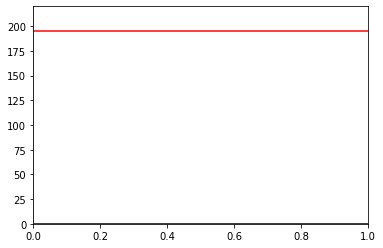

NameError: name 'envCartPole' is not defined

In [135]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()


envCartPole.close()